# Multimodal Embedding and Searching

Amazon Titan Multimodal Embedding Models can be used for enterprise tasks such as image search and similarity based recommendation, and has built-in mitigation that helps reduce bias in searching results. There are multiple embedding dimension sizes for best latency/accuracy tradeoffs for different needs, and all can be customized with a simple API to adapt to your own data while persists data security and privacy. Amazon Titan Multimodal Embedding models are provided as simple APIs for real-time or asynchronous batch transform searching and recommendation applications, and can be connected to different vector databases, including Amazon OpenSearch Service.

In this example notebook, we will demo to you how to generate embeddings for images and optionally texts using Amazon Titan Multimodal Embedding Models, then search the embeddings with a query.

## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, make sure you've completed the setup in the ['Getting Started' section of the root README](https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/README.md#Getting-started). ⚠️ ⚠️ ⚠️


Make sure you have enabled `amazon.titan-embed-image-v1` and `amazon.titan-image-generator-v1` model access.

In [10]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import re
import boto3
import json
import base64
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO
from scipy.spatial.distance import cdist

In [12]:
boto3_session = boto3.session.Session()
region_name = boto3_session.region_name
bedrock_client = boto3.client(
    "bedrock-runtime",
    region_name,
)

## Synthetic Dataset

We can leverage Amazon Bedrock Language Models to randomly generate 7 different products, each with 3 variants, using prompt:

```
Generate a list of 7 items description for an online e-commerce shop, each comes with 3 variants of color or type. All with separate full sentence description.
```

Note that when using different language models, the reponses might be different. For illustration purpose, suppose we get the below response.

In [13]:
response = 'Here is a list of 7 items with 3 variants each for an online e-commerce shop, with separate full sentence descriptions:\n\n1. T-shirt\n- A red cotton t-shirt with a crew neck and short sleeves. \n- A blue cotton t-shirt with a v-neck and short sleeves.\n- A black polyester t-shirt with a scoop neck and cap sleeves.\n\n2. Jeans\n- Classic blue relaxed fit denim jeans with a mid-rise waist. \n- Black skinny fit denim jeans with a high-rise waist and ripped details at the knees.  \n- Stonewash straight leg denim jeans with a standard waist and front pockets.\n\n3. Sneakers  \n- White leather low-top sneakers with an almond toe cap and thick rubber outsole.\n- Gray mesh high-top sneakers with neon green laces and a padded ankle collar. \n- Tan suede mid-top sneakers with a round toe and ivory rubber cupsole.  \n\n4. Backpack\n- A purple nylon backpack with padded shoulder straps, front zipper pocket and laptop sleeve.\n- A gray canvas backpack with brown leather trims, side water bottle pockets and drawstring top closure.  \n- A black leather backpack with multiple interior pockets, top carry handle and adjustable padded straps.\n\n5. Smartwatch\n- A silver stainless steel smartwatch with heart rate monitor, GPS tracker and sleep analysis.  \n- A space gray aluminum smartwatch with step counter, phone notifications and calendar syncing. \n- A rose gold smartwatch with activity tracking, music controls and customizable watch faces.  \n\n6. Coffee maker\n- A 12-cup programmable coffee maker in brushed steel with removable water tank and keep warm plate.  \n- A compact 5-cup single serve coffee maker in matt black with travel mug auto-dispensing feature.\n- A retro style stovetop percolator coffee pot in speckled enamel with stay-cool handle and glass knob lid.  \n\n7. Yoga mat \n- A teal 4mm thick yoga mat made of natural tree rubber with moisture-wicking microfiber top.\n- A purple 6mm thick yoga mat made of eco-friendly TPE material with integrated carrying strap. \n- A patterned 5mm thick yoga mat made of PVC-free material with towel cover included.'
print(response)

Here is a list of 7 items with 3 variants each for an online e-commerce shop, with separate full sentence descriptions:

1. T-shirt
- A red cotton t-shirt with a crew neck and short sleeves. 
- A blue cotton t-shirt with a v-neck and short sleeves.
- A black polyester t-shirt with a scoop neck and cap sleeves.

2. Jeans
- Classic blue relaxed fit denim jeans with a mid-rise waist. 
- Black skinny fit denim jeans with a high-rise waist and ripped details at the knees.  
- Stonewash straight leg denim jeans with a standard waist and front pockets.

3. Sneakers  
- White leather low-top sneakers with an almond toe cap and thick rubber outsole.
- Gray mesh high-top sneakers with neon green laces and a padded ankle collar. 
- Tan suede mid-top sneakers with a round toe and ivory rubber cupsole.  

4. Backpack
- A purple nylon backpack with padded shoulder straps, front zipper pocket and laptop sleeve.
- A gray canvas backpack with brown leather trims, side water bottle pockets and drawstrin

The following function converts the response to a list of descriptions. You may need to write your own function depending on the real response.

In [14]:
def extract_text(input_string):
    pattern = r"- (.*?)($|\n)"
    matches = re.findall(pattern, input_string)
    extracted_texts = [match[0] for match in matches]
    return extracted_texts

Convert the response to a list of product descriptions.

In [15]:
product_descriptions = extract_text(response)
product_descriptions

['A red cotton t-shirt with a crew neck and short sleeves. ',
 'A blue cotton t-shirt with a v-neck and short sleeves.',
 'A black polyester t-shirt with a scoop neck and cap sleeves.',
 'Classic blue relaxed fit denim jeans with a mid-rise waist. ',
 'Black skinny fit denim jeans with a high-rise waist and ripped details at the knees.  ',
 'Stonewash straight leg denim jeans with a standard waist and front pockets.',
 'White leather low-top sneakers with an almond toe cap and thick rubber outsole.',
 'Gray mesh high-top sneakers with neon green laces and a padded ankle collar. ',
 'Tan suede mid-top sneakers with a round toe and ivory rubber cupsole.  ',
 'A purple nylon backpack with padded shoulder straps, front zipper pocket and laptop sleeve.',
 'A gray canvas backpack with brown leather trims, side water bottle pockets and drawstring top closure.  ',
 'A black leather backpack with multiple interior pockets, top carry handle and adjustable padded straps.',
 'A silver stainless st

The following function calls bedrock to generated images using "amazon.titan-image-generator-v1" model.

In [16]:
def titan_image(
    payload:dict, 
    num_image:int=2, 
    cfg:float=10.0, 
    seed:int=2024
) -> list:

    body = json.dumps(
        {
            **payload,
            "imageGenerationConfig": {
                "numberOfImages": num_image,   # Number of images to be generated. Range: 1 to 5 
                "quality": "premium",          # Quality of generated images. Can be standard or premium.
                "height": 1024,                # Height of output image(s)
                "width": 1024,                 # Width of output image(s)
                "cfgScale": cfg,               # Scale for classifier-free guidance. Range: 1.0 (exclusive) to 10.0
                "seed": seed                   # The seed to use for re-producibility. Range: 0 to 214783647
            }
        }
    )

    response = bedrock_client.invoke_model(
        body=body, 
        modelId="amazon.titan-image-generator-v1", 
        accept="application/json", 
        contentType="application/json"
    )

    response_body = json.loads(response.get("body").read())
    images = [
        Image.open(
            BytesIO(base64.b64decode(base64_image))
        ) for base64_image in response_body.get("images")
    ]

    return images

Then we leverage the Titan Image Generation models to create product images for each of the descriptions. The following cell may take a few minutes to run.

In [17]:
embed_dir = "data/titan-embed"
os.makedirs(embed_dir, exist_ok=True)

titles = []
for prompt in product_descriptions:
    images = titan_image(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": prompt, # Required
            }
        },
        num_image=1
    )
    title = "_".join(prompt.split()[:4]).lower()
    title = f"{embed_dir}/{title}.png"
    titles.append(title)
    images[0].save(title, format="png")
    print(f"generated {title}")

generated data/titan-embed/a_red_cotton_t-shirt.png
generated data/titan-embed/a_blue_cotton_t-shirt.png
generated data/titan-embed/a_black_polyester_t-shirt.png
generated data/titan-embed/classic_blue_relaxed_fit.png
generated data/titan-embed/black_skinny_fit_denim.png
generated data/titan-embed/stonewash_straight_leg_denim.png
generated data/titan-embed/white_leather_low-top_sneakers.png
generated data/titan-embed/gray_mesh_high-top_sneakers.png
generated data/titan-embed/tan_suede_mid-top_sneakers.png
generated data/titan-embed/a_purple_nylon_backpack.png
generated data/titan-embed/a_gray_canvas_backpack.png
generated data/titan-embed/a_black_leather_backpack.png
generated data/titan-embed/a_silver_stainless_steel.png
generated data/titan-embed/a_space_gray_aluminum.png
generated data/titan-embed/a_rose_gold_smartwatch.png
generated data/titan-embed/a_12-cup_programmable_coffee.png
generated data/titan-embed/a_compact_5-cup_single.png
generated data/titan-embed/a_retro_style_stovet

# Multimodal Dataset Indexing

The following function converts image, and optionally, text, into multimodal embeddings.

In [18]:
def titan_multimodal_embedding(
    image_path:str=None,  # maximum 2048 x 2048 pixels
    description:str=None, # English only and max input tokens 128
    dimension:int=1024,   # 1,024 (default), 384, 256
    model_id:str="amazon.titan-embed-image-v1"
):
    payload_body = {}
    embedding_config = {
        "embeddingConfig": { 
             "outputEmbeddingLength": dimension
         }
    }

    # You can specify either text or image or both
    if image_path:
        with open(image_path, "rb") as image_file:
            input_image = base64.b64encode(image_file.read()).decode('utf8')
        payload_body["inputImage"] = input_image
    if description:
        payload_body["inputText"] = description

    assert payload_body, "please provide either an image and/or a text description"
    print("\n".join(payload_body.keys()))

    response = bedrock_client.invoke_model(
        body=json.dumps({**payload_body, **embedding_config}), 
        modelId=model_id,
        accept="application/json", 
        contentType="application/json"
    )

    return json.loads(response.get("body").read())

Now we can create embeddings for the generated images, together with the product descriptions.

In [19]:
multimodal_embeddings = []
for title in titles:
    embedding = titan_multimodal_embedding(image_path=title, dimension=1024)["embedding"]
    multimodal_embeddings.append(embedding)
    print(f"generated embedding for {title}")

inputImage
generated embedding for data/titan-embed/a_red_cotton_t-shirt.png
inputImage
generated embedding for data/titan-embed/a_blue_cotton_t-shirt.png
inputImage
generated embedding for data/titan-embed/a_black_polyester_t-shirt.png
inputImage
generated embedding for data/titan-embed/classic_blue_relaxed_fit.png
inputImage
generated embedding for data/titan-embed/black_skinny_fit_denim.png
inputImage
generated embedding for data/titan-embed/stonewash_straight_leg_denim.png
inputImage
generated embedding for data/titan-embed/white_leather_low-top_sneakers.png
inputImage
generated embedding for data/titan-embed/gray_mesh_high-top_sneakers.png
inputImage
generated embedding for data/titan-embed/tan_suede_mid-top_sneakers.png
inputImage
generated embedding for data/titan-embed/a_purple_nylon_backpack.png
inputImage
generated embedding for data/titan-embed/a_gray_canvas_backpack.png
inputImage
generated embedding for data/titan-embed/a_black_leather_backpack.png
inputImage
generated emb

In [20]:
np.array(multimodal_embeddings).shape, np.array(multimodal_embeddings)

((21, 1024),
 array([[ 0.0033732 , -0.0069338 , -0.031858  , ..., -0.0123684 ,
          0.0183652 , -0.017803  ],
        [ 0.01270323, -0.00117367, -0.03313887, ..., -0.02743162,
          0.00805458,  0.00888306],
        [-0.00486832,  0.01402433,  0.0042207 , ..., -0.0149176 ,
          0.02608347,  0.02143847],
        ...,
        [-0.00010136,  0.02190033, -0.04472085, ..., -0.00169083,
         -0.01959988,  0.01656328],
        [-0.01677535,  0.01879206, -0.02456718, ...,  0.00187921,
         -0.01420863,  0.01888373],
        [-0.00675687,  0.01944882, -0.02848841, ...,  0.00248817,
          0.00504482,  0.0111397 ]]))

The following function produces a heatmap to display the inner product of the embeddings.

In [21]:
def plot_similarity_heatmap(embeddings_a, embeddings_b):
    inner_product = np.inner(embeddings_a, embeddings_b)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )

Generate a heatmap to display the inner product of the embeddings. You can see that the diagonal is dark red, which means one embedding is closely related to itself. Then you can notice that there are 3X3 squares which are lighter than the diagonal, but darker than the rest. It means those 3 embeddings are less closely related to each other, than to itself, but more closely related to the rest embeddings. This makes sense, as we generated 3 variants of each product. Products are more closely related if they are of the same type. Products are less closely related if they are of different types.

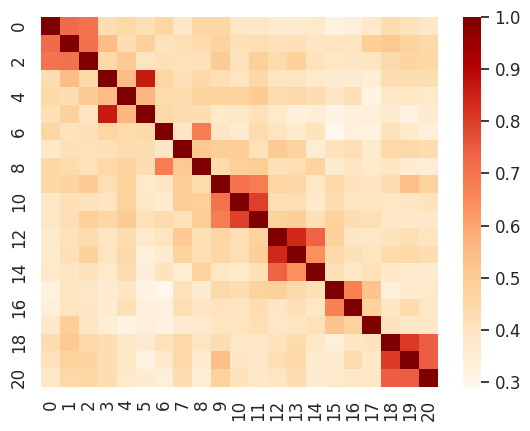

In [22]:
plot_similarity_heatmap(multimodal_embeddings, multimodal_embeddings)

# Multimodal Searching

The following function returns the top similar multimodal embeddings given a query multimodal embedding. Note in practise you can leverage managed vector database, e.g. Amazon OpenSearch Service, and here is for illustration purpose.

In [23]:
def search(query_emb:np.array, indexes:np.array, top_k:int=1):
    dist = cdist(query_emb, indexes, metric="cosine")
    return dist.argsort(axis=-1)[0,:top_k], np.sort(dist, axis=-1)[:top_k]

Now we have created the embeddings, we can search the list with a query, to find the product which the query best describes.

In [24]:
query_prompt = "suede sneaker"
query_emb = titan_multimodal_embedding(description=query_prompt, dimension=1024)["embedding"]
len(query_emb)

inputText


1024

In [25]:
idx_returned, dist = search(
    np.array(query_emb)[None], 
    np.array(multimodal_embeddings)
)
idx_returned, dist

(array([8]),
 array([[0.54907763, 0.61941285, 0.64927568, 0.67163579, 0.71442721,
         0.72148688, 0.72266536, 0.72622931, 0.72699182, 0.73203663,
         0.73463636, 0.73961395, 0.74105495, 0.74377832, 0.74517907,
         0.7492697 , 0.75372575, 0.75663575, 0.75955728, 0.76261057,
         0.76795449]]))

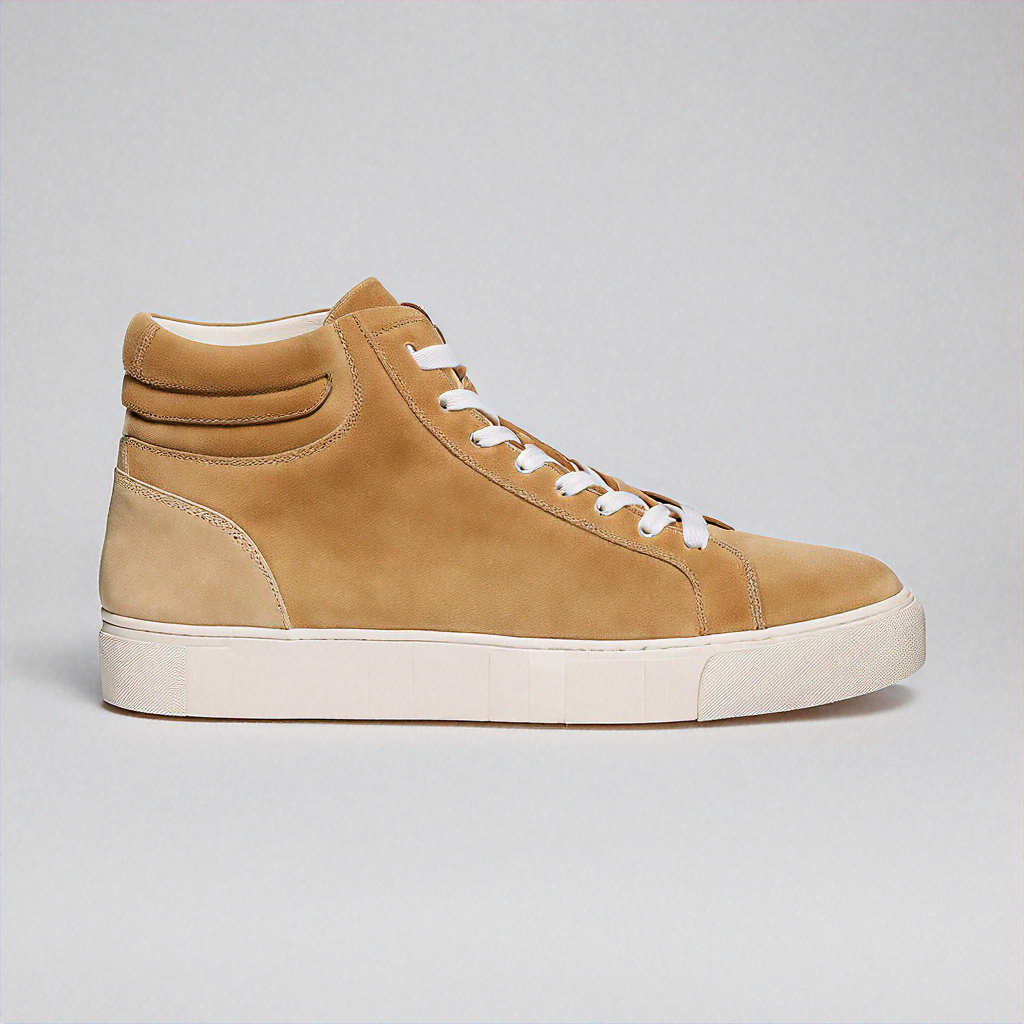

In [26]:
for idx in idx_returned[:1]:
    display(Image.open(f"{titles[idx]}"))

Let's convert the above cells to a helper function.

In [27]:
def multimodal_search(description:str, dimension:int):
    query_emb = titan_multimodal_embedding(description=description, dimension=dimension)["embedding"]

    idx_returned, dist = search(
        np.array(query_emb)[None], 
        np.array(multimodal_embeddings)
    )

    for idx in idx_returned[:1]:
        display(Image.open(f"{titles[idx]}"))

inputText


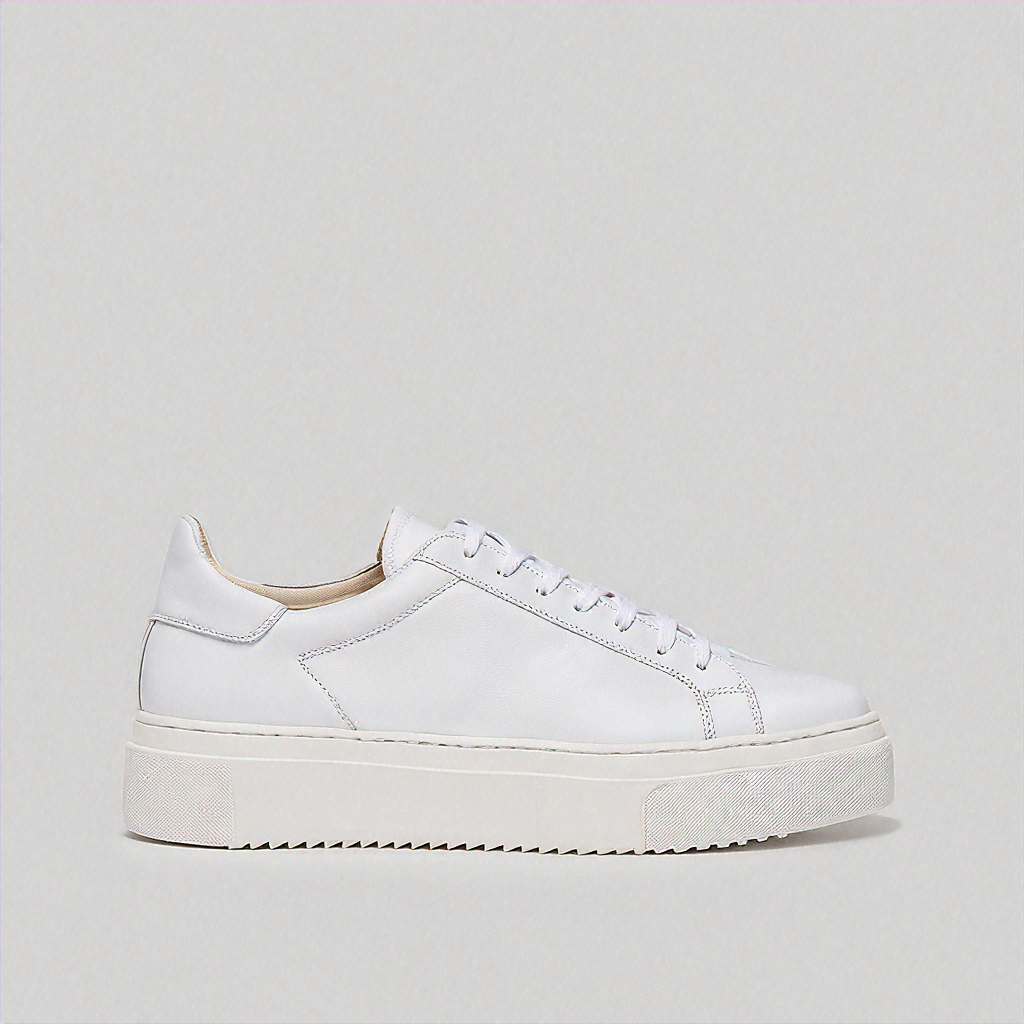

In [28]:
multimodal_search(description="white sneaker", dimension=1024)

In [ ]:
multimodal_search(description="mesh sneaker", dimension=1024)

In [ ]:
multimodal_search(description="leather backpack", dimension=1024)

In [ ]:
multimodal_search(description="nylon backpack", dimension=1024)

inputText


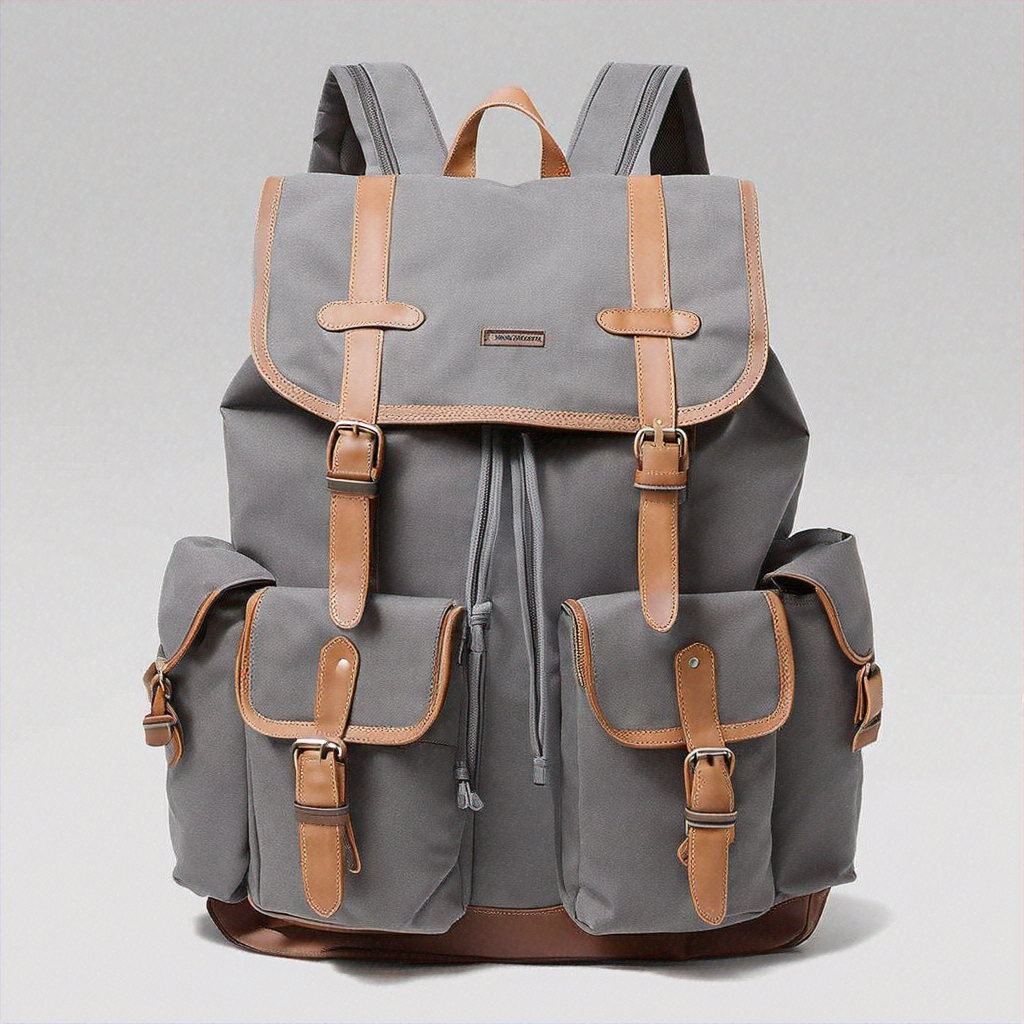

In [29]:
multimodal_search(description="canvas backpack", dimension=1024)

In [ ]:
multimodal_search(description="running shoes", dimension=1024)